In [1]:
import scanpy as sc
import cellrank as cr
from cellrank.kernels import RealTimeKernel
from moscot.problems.time import TemporalProblem
import pandas as pd
import numpy as np
import os

# 设置最大线程数

os.environ["OMP_NUM_THREADS"] = "40"
os.environ["OPENBLAS_NUM_THREADS"] = "40"
os.environ["MKL_NUM_THREADS"] = "40"
os.environ["VECLIB_MAXIMUM_THREADS"] = "40"
os.environ["NUMEXPR_NUM_THREADS"] = "40"


In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep.prcessed.h5ad')

In [3]:
adata.obs['day'] = 2
adata.obs.loc[adata.obs['celltype'] == 'early', 'day'] = 1

In [4]:
tp = TemporalProblem(adata)

In [5]:
tp = tp.prepare(time_key="day")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


In [6]:
tp = tp.solve()

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1139, 6998)].                                  


WARNING  Solver did not converge                                                                                   


In [7]:
tmk = RealTimeKernel.from_moscot(tp)

In [8]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|██████████| 1/1 [00:00<00:00, 7410.43time pair/s]


RealTimeKernel[n=8137, threshold='auto', self_transitions='all']

In [9]:
g = cr.estimators.GPCCA(tmk)
g

GPCCA[kernel=RealTimeKernel[n=8137], initial_states=None, terminal_states=None]

In [10]:
g.fit(cluster_key="celltype", n_states=2)

GPCCA[kernel=RealTimeKernel[n=8137], initial_states=None, terminal_states=None]

In [11]:
adata.obs.celltype.value_counts()

celltype
dead-end         3814
reprogramming    3184
early            1139
Name: count, dtype: int64

In [12]:
g.set_terminal_states(states=["dead-end", "reprogramming"])

GPCCA[kernel=RealTimeKernel[n=8137], initial_states=None, terminal_states=['dead-end', 'reprogramming']]

/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


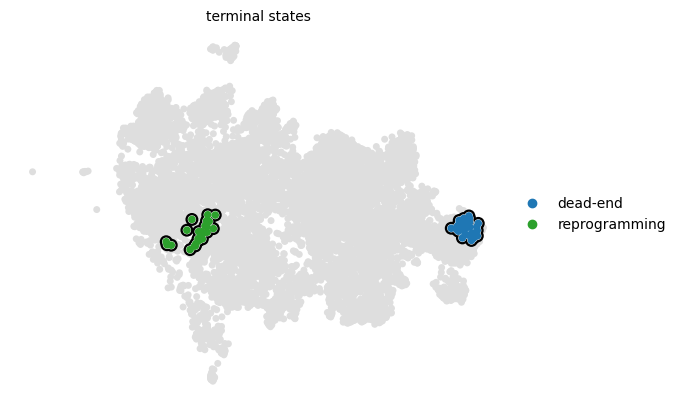

In [13]:
g.plot_macrostates(which="terminal", legend_loc="right", size=100)

In [14]:
g.compute_fate_probabilities()

Defaulting to `'gmres'` solver.


100%|██████████| 2/2 [00:00<00:00,  7.20/s]


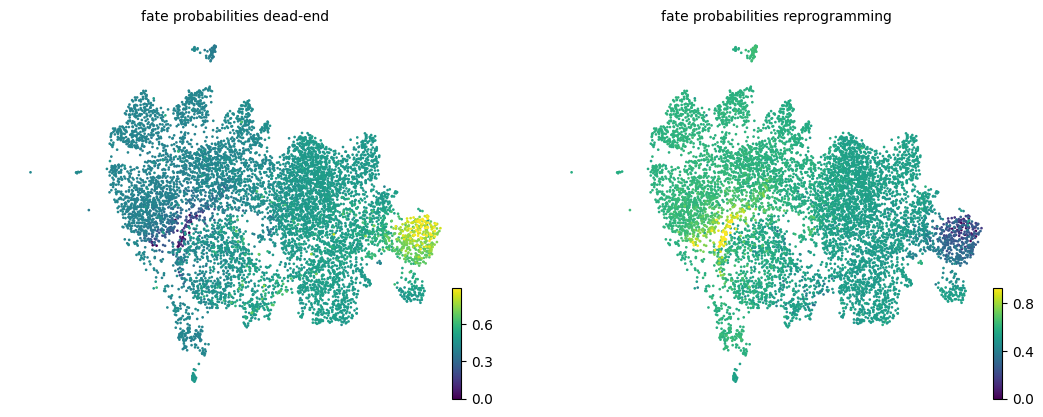

In [15]:
g.plot_fate_probabilities(same_plot=False)

In [38]:
df1=pd.DataFrame(g.adata.obsm['lineages_fwd'],columns=['dead-end','reprogramming'])

In [49]:
max_columns = df1.idxmax(axis=1)


In [50]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
adata.obs['pred'] = max_columns.tolist()
adata_final = adata[adata.obs.celltype=='early']
y_pred = adata_final.obs['pred']
y_true = adata_final.obs['lineage']

# 计算准确性

accuracy = accuracy_score(y_true, y_pred)

# 计算召回率

recall = recall_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 计算F1分数

f1 = f1_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 输出结果

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7497805092186128
Recall: 0.6018442110527632
F1 Score: 0.611202736546332


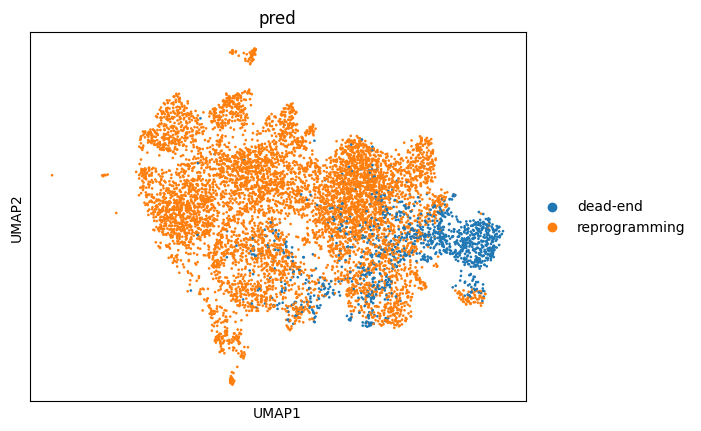

In [52]:
sc.pl.umap(adata,color='pred')

In [51]:
adata.write('/data/jiangjunyao/AEGAS_analysis/pred_result/cellrank_celltag_multi_rna_hvg.h5ad')
adata.obs.to_csv('/data/jiangjunyao/AEGAS_analysis/pred_result/cellrank_celltag_multi_rna_obs.csv')